In [1]:
import sqlite3

database = sqlite3.connect(r"C:\\Users\\swavi\\Documents\\GitHub\\F1-Stop-Strategy\\Databases\\database.db")
cursor = database.cursor()
driverIds = []
year = 2025

cursor.execute(
		"""SELECT raceID FROM Race WHERE year = ?""",
				(year,)
					)
races = [r[0] for r in cursor.fetchall()]


def getDrivers(raceId):
		cursor.execute(
			"""
			SELECT DISTINCT d.driverId, d.code
			FROM Driver d
			JOIN LAP l ON l.driverId = d.driverId
			WHERE l.raceId = ?
			""",
			(raceId,)
		)
		drivers = cursor.fetchall()
		return drivers


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import numpy as np
plt.ioff()
scaler = StandardScaler()


allLaps = []
allDrivers = []

columns = [
    "throttlePerc100",
    "throttlePerc0",
    "avCornerBrakeDistance",
    "throttleOscillation",
    "coastingPerc",
    "brakeChanges",
    "avSpeedCornerDiff",
    "avApexThrottle",
]


data = {col: [] for col in columns}

In [3]:
def collectingData(race, driverIds, driverCodes, averages):
  rows = []

  for driverId, driverCode in zip(driverIds, driverCodes):
    cursor.execute(
      """SELECT lapId
         FROM Lap 
         WHERE raceId = ? AND driverId = ? AND attacking = ? AND defending = ?""",
      (race, driverId, 0, 0)
    )

    lapIds = [laps[0] for laps in cursor.fetchall()]
    lapFeatures = []

    for lapId in lapIds:
      cursor.execute(
        f"""SELECT {",".join(columns)}
            FROM Features
            WHERE lapId = ?""",
        (lapId,)
      )

      row = cursor.fetchone()

      if row is None:
        continue
      if all(feature is not None for feature in row):
        lapFeatures.append(row)

    lapFeatures = np.array(lapFeatures, dtype=float)
    if lapFeatures.shape[0] == 0:
      continue

    if averages:
      values = lapFeatures.mean(axis=0)
      rows.append(
        dict(zip(columns, values), driver=driverCode, raceId=race)
      )
    else:
      rows.extend(
          dict(zip(columns, row), driver=driverCode, raceId=race)
          for row in lapFeatures)
  return pd.DataFrame(rows)


In [4]:
averages = False
rows = []

for race in races:
		drivers = getDrivers(race)
		driverIds = [row[0] for row in drivers]
		driverCodes = [row[1] for row in drivers]
		dfRace = (collectingData(race,driverIds,driverCodes,averages))
		rows.append(dfRace)

df = pd.concat(rows, ignore_index=True)
df[columns] = df.groupby("raceId")[columns].transform(
    lambda x: (x - x.mean()) / x.std()
)

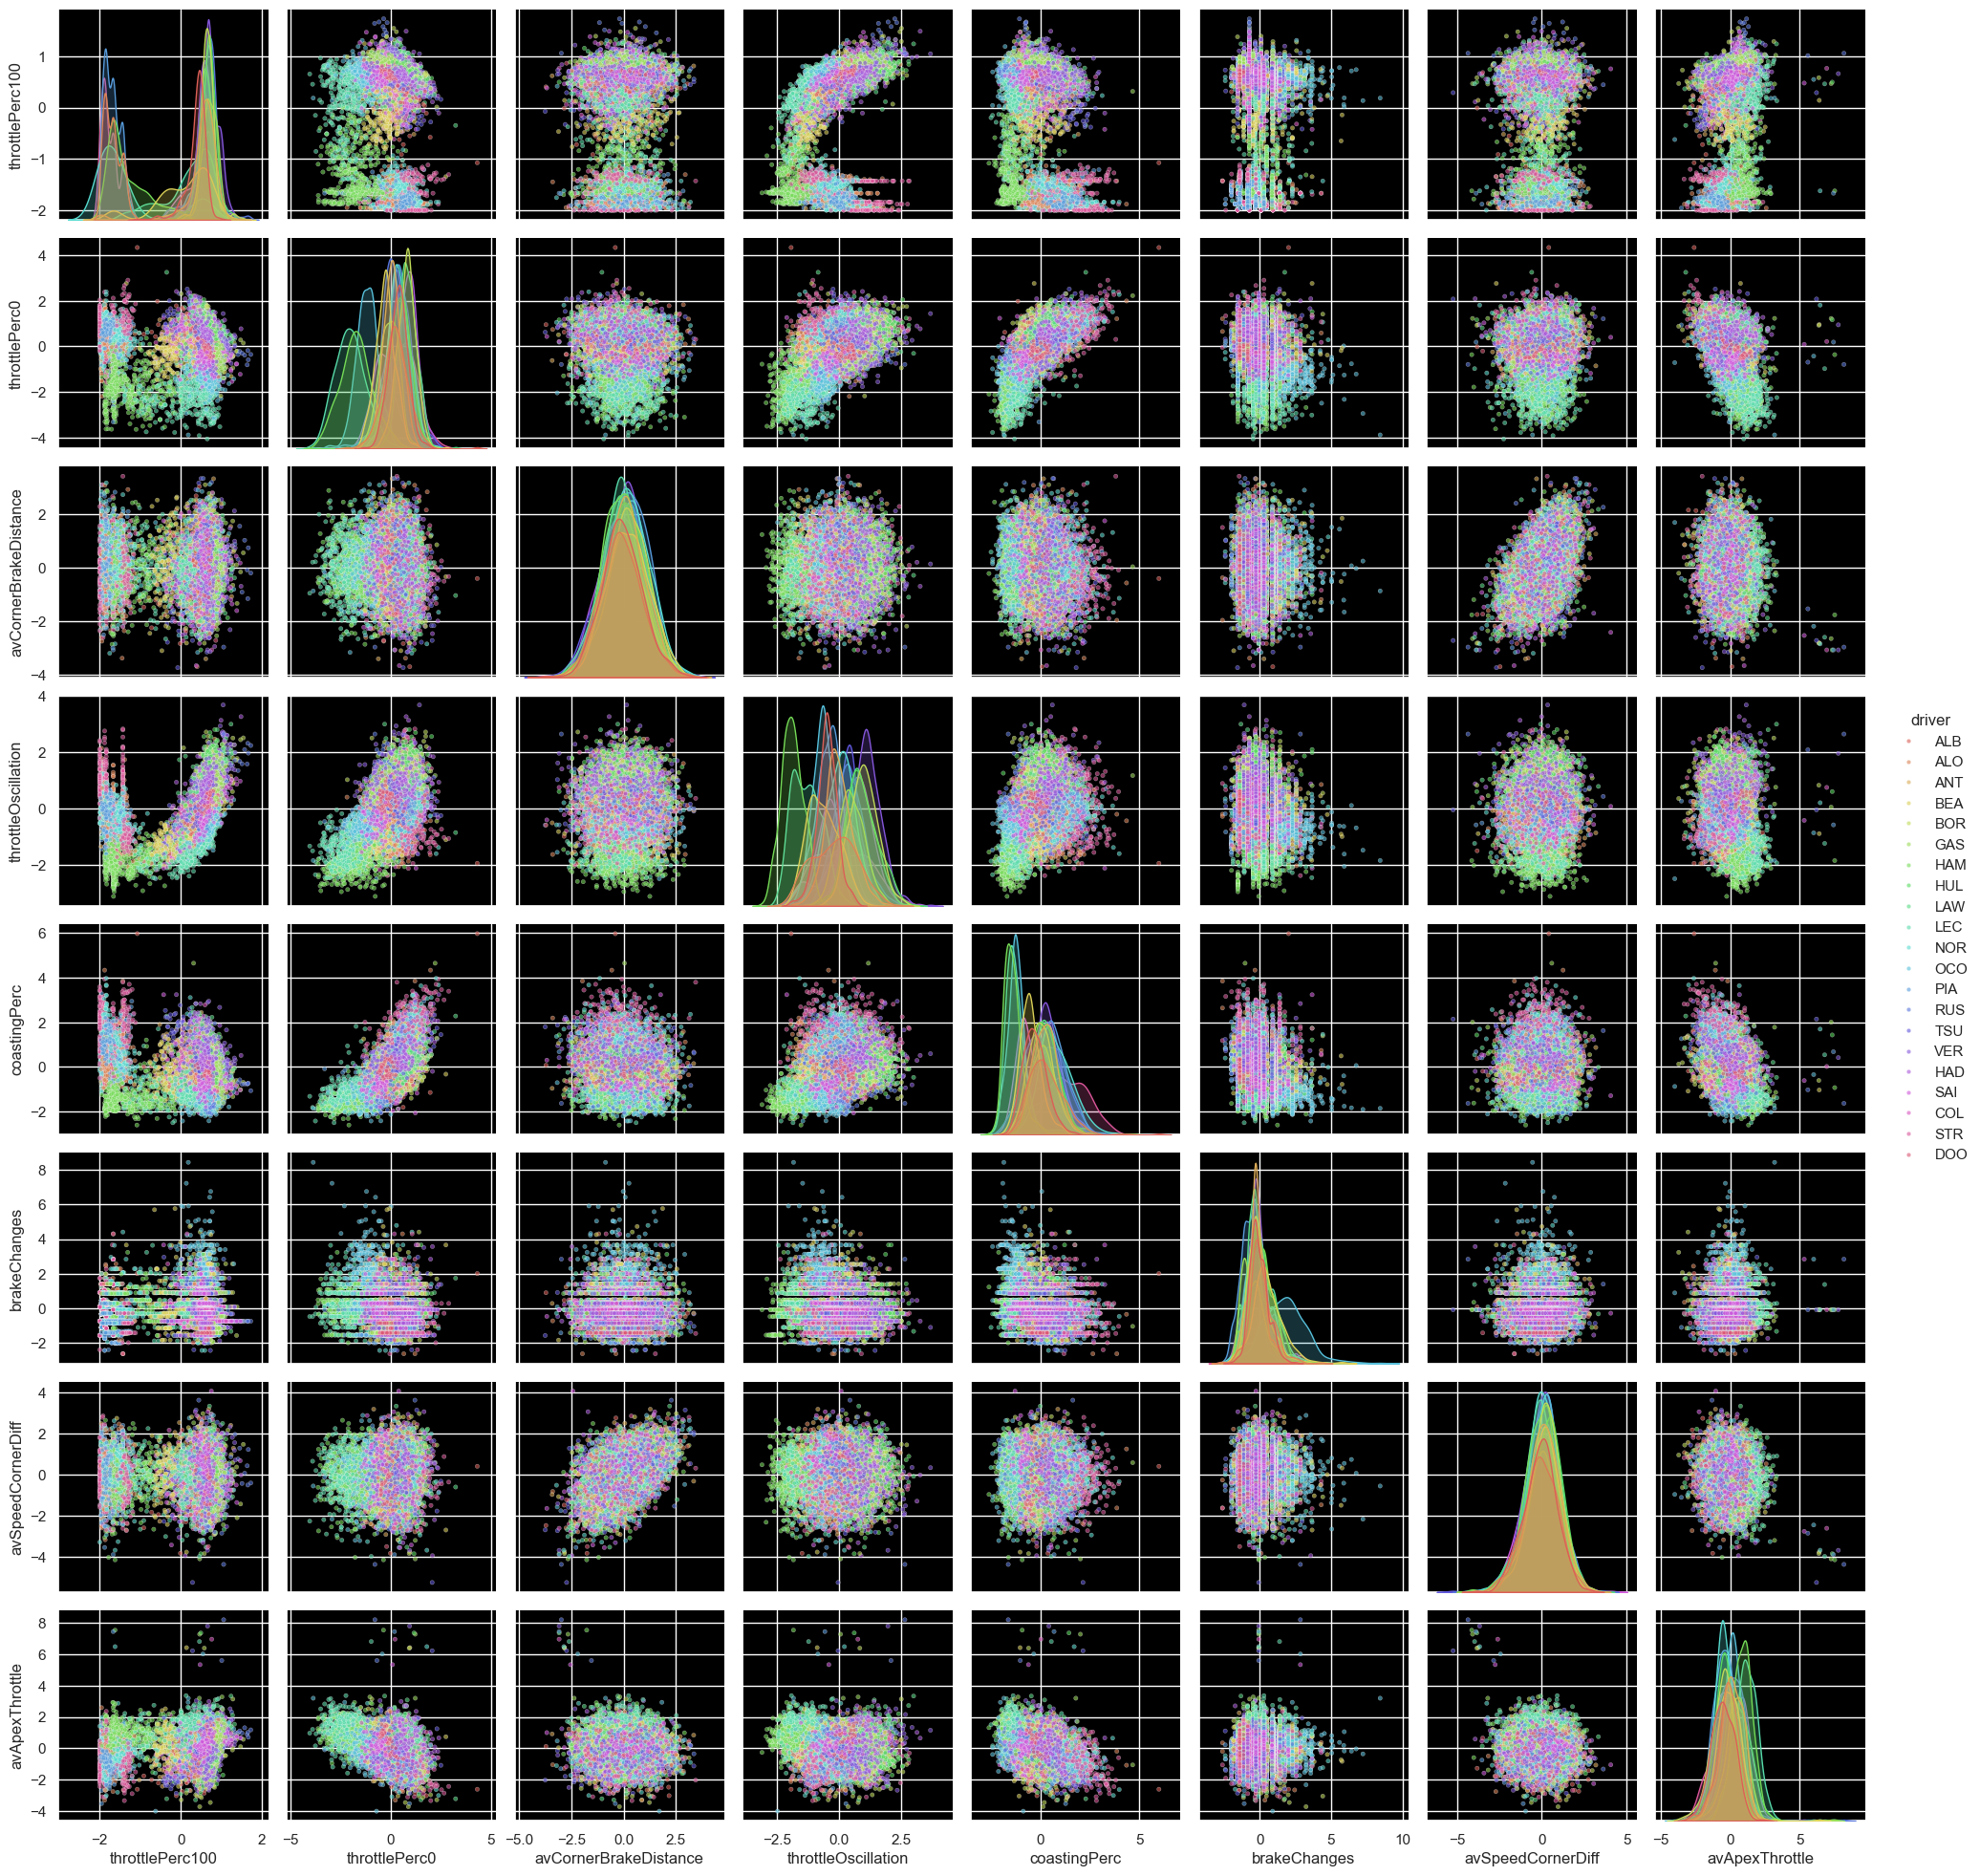

In [5]:
palette = sns.color_palette("hls", len(df['driver'].unique()))
uniqueDrivers = df['driver'].unique()
driverColours = {uniqueDrivers[i]: palette[i] for i in range(len(uniqueDrivers))}


sns.set(rc={'axes.facecolor': 'black', 'figure.facecolor': 'white'})

sns.pairplot(
    df,
    vars=columns,
    hue="driver",
    palette=driverColours,
    plot_kws={"s": 10, "alpha": 0.6}
)
plt.show()

In [23]:
from hdbscan import HDBSCAN

features = columns  
allLapsDF = df[features].copy()
scaler = StandardScaler()
scaled = scaler.fit_transform(allLapsDF)
pca = PCA(n_components=2)
Xpca = pca.fit_transform(scaled)
hdb = HDBSCAN(min_cluster_size=60, min_samples=30,
                      cluster_selection_method='leaf', metric='euclidean',prediction_data=True)
labels = hdb.fit_predict(Xpca)
from sklearn.metrics import silhouette_score
print("Silhouette score:", silhouette_score(Xpca, labels))
df = df.reset_index(drop=True) 
df["cluster"] = labels
clusterSummary = df.groupby("cluster")[features].mean()
clusterAssignment = pd.crosstab(df.driver, df.cluster)
clusterAssignmentPercentage = (clusterAssignment.div(clusterAssignment.sum(axis=0),axis=1) *100).round(2)
print(clusterAssignment)

Silhouette score: -0.45239806240046315
cluster   -1   0   1   2   3   4
driver                          
ALB      353   0   2   9   3  12
ALO      342   0   3   8   2  10
ANT      397   0   1  16   2  14
BEA      398   3   0   3   0   1
BOR      397   0   5   9   4  20
COL      184   0   2   2   1   5
DOO      151   0   0   4   2   9
GAS      316   0   5  11   5  11
HAD      379   0   7   4   8  18
HAM      444  21   0   0   0   1
HUL      384   0   9  11  13  18
LAW      390   0   5   7   3  19
LEC      451  26   0   0   0   0
NOR      449   0   5  17   1  24
OCO      427  22   0   0   0   0
PIA      440   1   9  16   3  26
RUS      428   1   1  13   3  10
SAI      391   0   2   6   0   7
STR      363   0   1   6   1   9
TSU      386   0   4   9   3  14
VER      439   0   3   6   7  24


In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

features = columns
allLapsDF = df[features].copy()

# Scale
scaler = StandardScaler()
scaled = scaler.fit_transform(allLapsDF)

# Reduce to behaviour space
pca = PCA(n_components=2)
Xpca = pca.fit_transform(scaled)

# Cluster
kmeans = KMeans(n_clusters=7, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xpca)

# Evaluate
print("Silhouette score:", silhouette_score(Xpca, labels))

# Attach to data
df = df.reset_index(drop=True)
df["cluster"] = labels

# Interpret
clusterSummary = df.groupby("cluster")[features].mean()
clusterAssignment = pd.crosstab(df.driver, df.cluster)
clusterAssignmentPercentage = (
        clusterAssignment.div(clusterAssignment.sum(axis=0), axis=1) * 100
).round(2)

print(clusterAssignment)

Silhouette score: 0.31965731978173967
cluster    0    1    2    3    4    5    6
driver                                    
ALB       15   50   26  169    1   54   64
ALO       29   53   26  132    0   58   67
ANT       27   62   24  170    0   63   84
BEA        0  192   77   76   12   25   23
BOR      129    6    4   89    0   57  150
COL       28   35   16   53    0   42   20
DOO        7   18    9   72    0   32   28
GAS       28   33   25  144    0   61   57
HAD      131    4    3  106    0  113   59
HAM        0   33   95    2  334    1    1
HUL      106   24    7  115    0   63  120
LAW      119    3    2  110    0  110   80
LEC        1   36  136   11  293    0    0
NOR       96   30    8  137    1   57  167
OCO        0  159  139    5  144    1    1
PIA       85   72    9  115    4   54  156
RUS       39   81   30  163    1   75   67
SAI       33  103   52   99    6   70   43
STR      168   21    9   63    1   44   74
TSU      108   15   12  105    0   87   89
VER      127   1

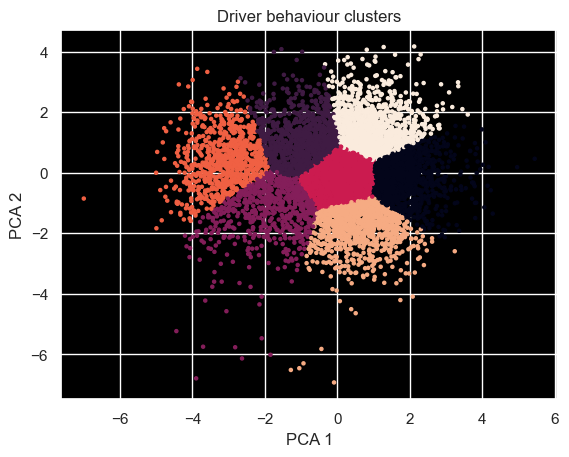

In [38]:
plt.scatter(Xpca[:,0], Xpca[:,1], c=labels, s=5)
plt.title("Driver behaviour clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [29]:
# Format the cluster assignment table
styled_cluster_assignment = clusterAssignment.style\
    .background_gradient(cmap='Blues')\
    .format(precision=0)\
    .set_caption('Driver Cluster Assignments (Counts)')\
    .set_table_styles([
        {'selector': 'caption', 
         'props': [('font-size', '16px'), 
                   ('font-weight', 'bold'),
                   ('text-align', 'center'),
                   ('padding', '10px')]},
        {'selector': 'th', 
         'props': [('background-color', '#f2f2f2'),
                   ('font-weight', 'bold'),
                   ('padding', '8px'),
                   ('text-align', 'center')]},
        {'selector': 'td', 
         'props': [('padding', '6px'),
                   ('text-align', 'center')]}
    ])

# Display the styled table
styled_cluster_assignment

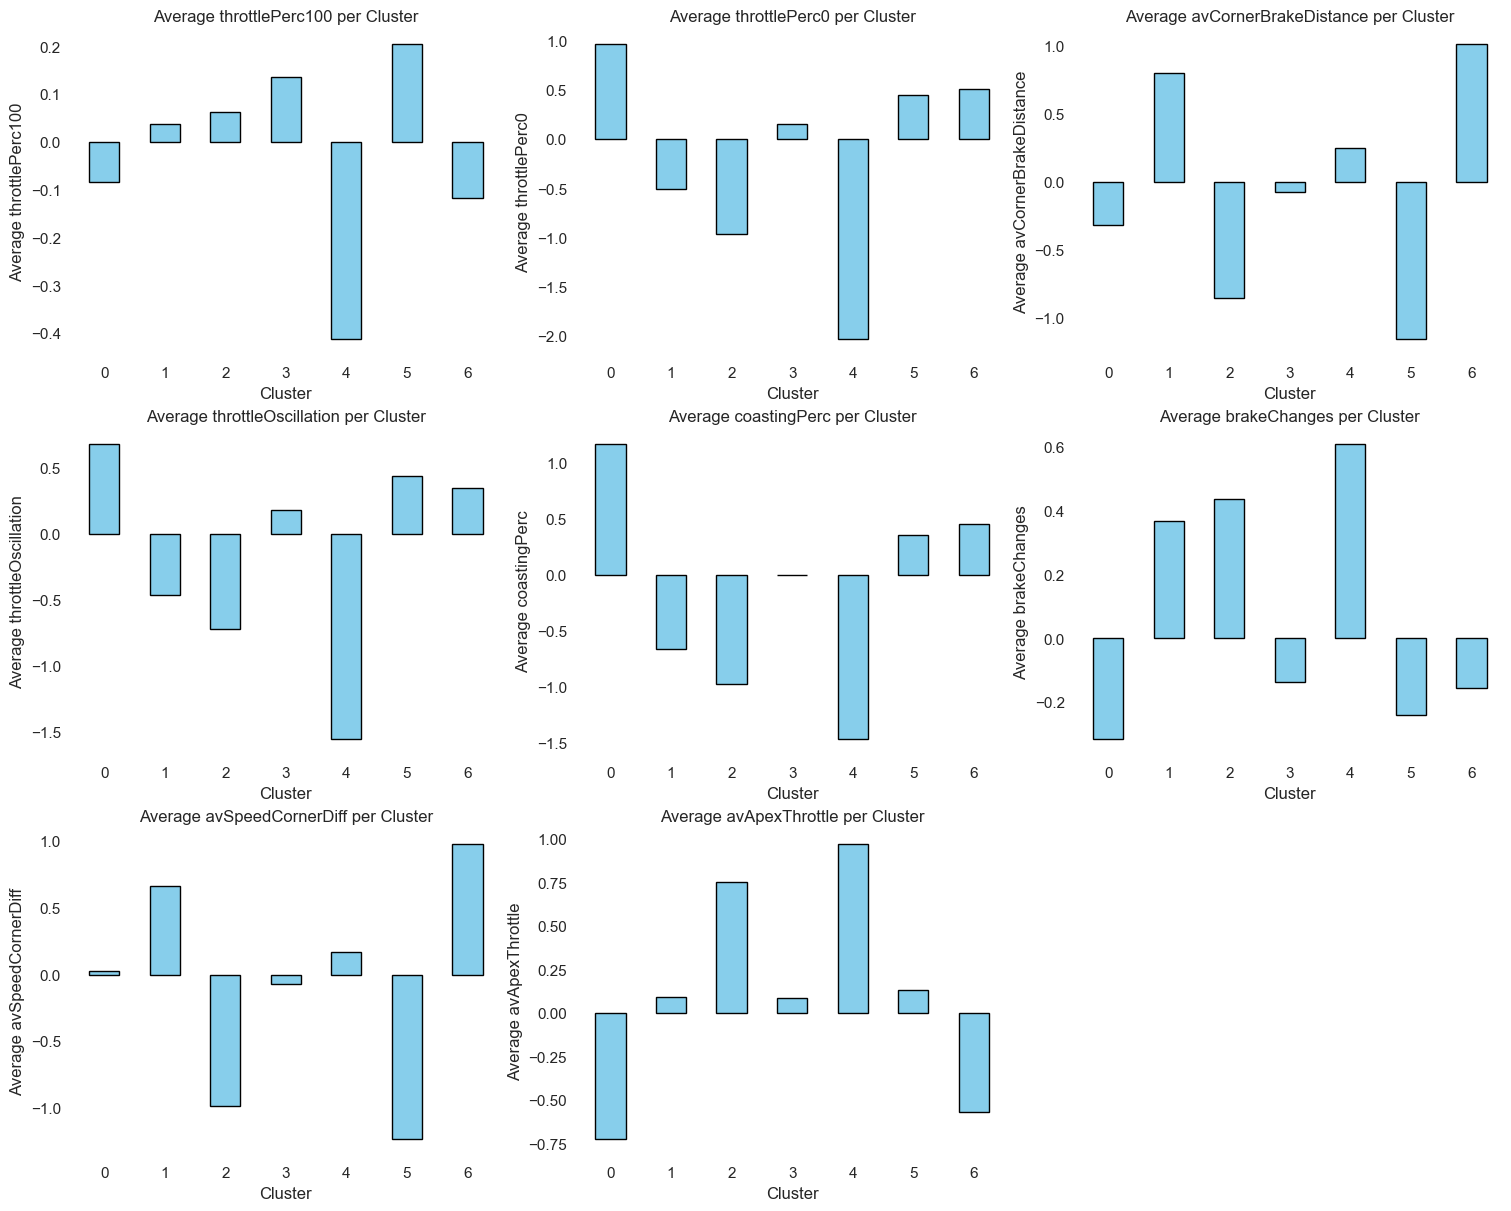

In [30]:
columns = clusterSummary.columns
nColumns = len(columns)
nRows = int(np.ceil(nColumns/3))
fig, axes = plt.subplots(nRows, 3, figsize=(
    15, 4*nRows), constrained_layout=True, facecolor='white')
if nRows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for index, col in enumerate(columns):
    ax = axes[index]
    clusterSummary[col].plot(
        kind='bar', color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(f'Average {col} per Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'Average {col}')
    ax.set_facecolor('white')
    ax.tick_params(rotation=0)

for index in range(len(columns), len(axes)):
    axes[index].set_visible(False)
plt.show()

In [40]:
def analyse_lap(testLap):
    scaled = scaler.transform(testLap[columns])
    pcaLap = pca.transform(scaled)
    cluster = kmeans.predict(pcaLap)[0]
    print("Predicted cluster:", cluster)

    drivers = clusterAssignmentPercentage[cluster].sort_values(ascending=False)
    drivers = drivers[drivers > 0]
    print("Most likely drivers for this lap:\n", drivers.head(5))

testingLap = pd.DataFrame([{
    "throttlePerc100": 48,
    "throttlePerc0": 17,
    "avCornerBrakeDistance": 42,
    "throttleOscillation": 7,
    "coastingPerc": 2.3,
    "brakeChanges": 120,
    "avSpeedCornerDiff": 35,
    "avApexThrottle": 62
}])

analyse_lap(testingLap)



Predicted cluster: 4
Most likely drivers for this lap:
 driver
HAM    41.91
LEC    36.76
OCO    18.07
BEA     1.51
SAI     0.75
Name: 4, dtype: float64


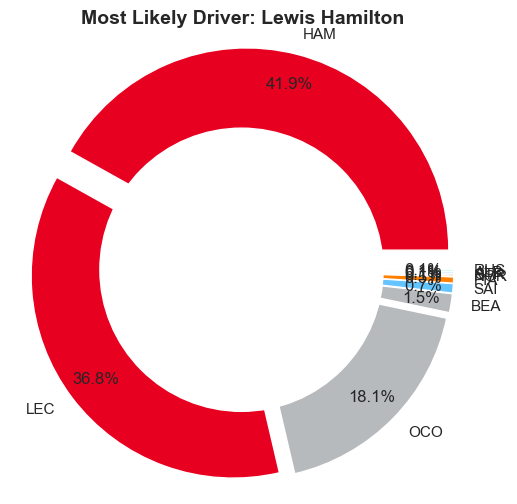

In [33]:
import matplotlib.pyplot as plt
import numpy as np

top_idx = np.argmax(driverValues)
top_driver = driverNames[top_idx]

cursor.execute(
    """
    SELECT code, name, teamColour
    FROM Driver
    WHERE code IN ({})
    """.format(",".join("?" * len(driverNames))),
    driverNames
)

rows = cursor.fetchall()

codeName = {code: name for code, name, _ in rows}
codeColour = {code: f"#{colour}" for code, _, colour in rows}

displayNames = [codeName[c] for c in driverNames]
colours = [codeColour[c] for c in driverNames]

top_idx = np.argmax(driverValues)
top_driver = displayNames[top_idx]

explode = [0.05] * len(displayNames)
explode[top_idx] = 0.10

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    driverValues,
    labels=driverNames,
    colors=colours,
    explode=explode,
    autopct='%1.1f%%',
    pctdistance=0.85
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)

ax.set_title(
    f"Most Likely Driver: {top_driver}",
    fontsize=14,
    weight='bold'
)

ax.axis('equal')
plt.show()


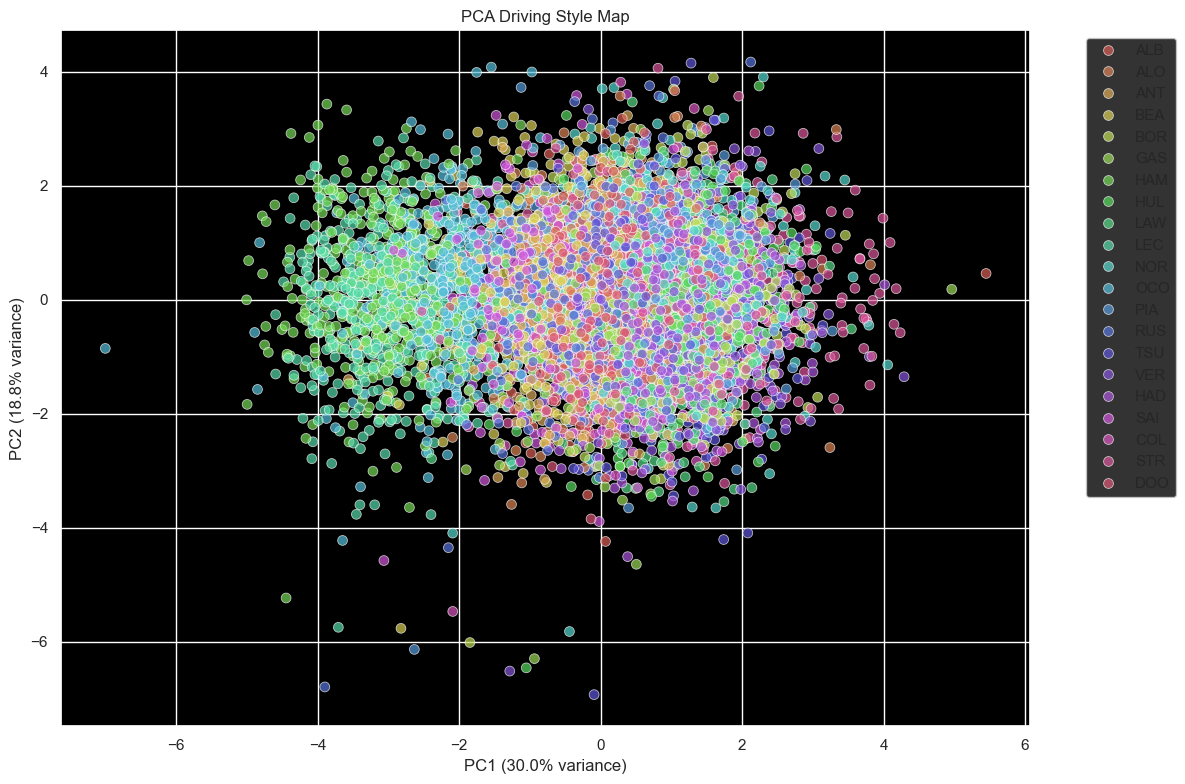

In [41]:
df['PC1'] = Xpca[:, 0]
df['PC2'] = Xpca[:, 1]

plt.figure(figsize=(12, 8))
uniqueDrivers = df['driver'].unique()
palette = sns.color_palette("hls", len(uniqueDrivers))
driverColors = {driver: palette[i] for i, driver in enumerate(uniqueDrivers)}

sns.scatterplot(
    x='PC1', y='PC2',
    hue='driver',
    data=df,
    palette=driverColors,
    alpha=0.7,
    s=50
)

plt.title("PCA Driving Style Map")
plt.gca().set_facecolor('black')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = Xpca
y = df['driver']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print("Driver identification accuracy:", accuracy_score(y_test, preds))

Driver identification accuracy: 0.12863849765258217


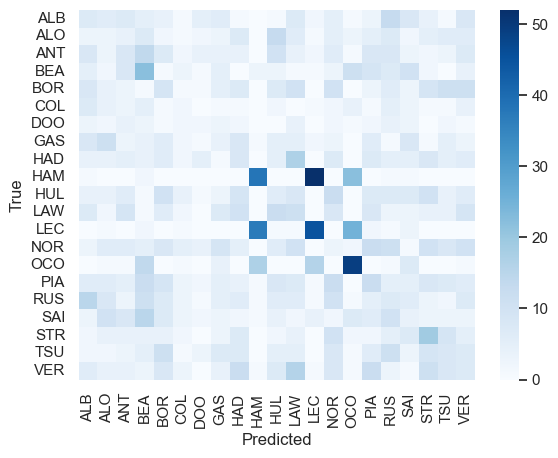

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, preds, labels=rf.classes_)
sns.heatmap(cm, xticklabels=rf.classes_, yticklabels=rf.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()